<a href="https://colab.research.google.com/github/TommasoPeviani/NN4DS_FinalHomework/blob/main/AML_2024_Assignment_4_Peviani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2023-2024

## Home Project #4##
## Tommaso Peviani


**Scope:** implement a ViT architecture ([Dosovitskiy et al., An Image Is Worth 16X16 Words: Transformers for image recongition at scale](https://arxiv.org/pdf/2010.11929.pdf)), and train it for the task of hadronic jet tagging.


**Task:** jet tagging (e.g. classification of jets originating from different particles: *gluons, quarks, Ws, Zs, and top quarks*).

**Physics context:** <p>
At the extreme energies of the Large Hadron Collider, massive particles can be produced with such high Lorentz boost that their decays into hadrons (hadron jets) are collimated in such a way that the resulting particles overlap. Deducing whether the substructure of an observed jet is due to a single low-mass particle or to multiple decay objects of a high-mass particle is an important problem in LHC data analysis. Traditional approaches are based on high-level observables built from theoretical models of energy deposition in calorimeters and charged tracks parameters reconsrtcuted in the inner tracker, but the complexity of the data makes this task an excellent candidate for the application of deep learning tools. The jet constituents can be in fact represented either as 2D or 3D images,lending itself to the natural application of image classification techniques (CNN, ViT etc.), or as pointclouds/graphs, that can be classified with GNNs, or as sequences, that can be analysed by RNNs or Transformers.

**Dataset:** <p>
The dataset is the *JetDataset*, in paricular the dataset that includes jet rapresentation through images.

**NOTE:** when done, upload the notebook of the project on: [dowlnload form](https://elearning.uniroma1.it/mod/assign/view.php?id=638441) (deadline: May 8th h15:59)

## Imports

In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import glob

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.2.1+cu121
0.17.1+cu121


In [ ]:
# dataset download
# we'll clone a github repository from M. Pierini containing the dataset
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 707, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 707 (delta 58), reused 105 (delta 35), pack-reused 579
Receiving objects: 100% (707/707), 566.43 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Updating files: 100% (79/79), done.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_40000_50000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_50000_60000.h5	jetImage_7_100p_80000_90000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_60000_70000.h5


In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [ ]:
%pip install onnx onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.9/598.9 kB 41.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AML4PH/Assignment_4/'


Mounted at /content/drive


## Data Handling

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top, based on a **jet image**, i.e., a **2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100 bins of a square window of the ($\eta,\phi$) plane, centered along the jet axis**.

The jet images are stored in the 'jetImage' container.

The ground truth is incorporated in a ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form:

* $[1, 0, 0, 0, 0]$ for gluons
* $[0, 1, 0, 0, 0]$ for quarks
* $[0, 0, 1, 0, 0]$ for W bosons (with W  qq)
* $[0, 0, 0, 1, 0]$ for Z bosons (with Z  qq)
* $[0, 0, 0, 0, 1]$ for top quarks (with t  Wq  qqq)

This is what is called 'one-hot' encoding of a discrete label (typical of ground truth for classification problems).

In [ ]:
# data is stored in hirearchical data format (h5), a file format desgined to store and maniuplate large size data structures
# .h5 files can be accesses in python using the h5py library (https://docs.h5py.org/en/stable/)

# read dataset (only 50k events to keep training time ~20' on google colab, better performance can be obtained adding the three commented files
target = np.array([])
jetImage = np.array([])
datafiles = [#'tutorials/Data/JetDataset/jetImage_7_100p_80000_90000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_70000_80000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
             #'tutorials/Data/JetDataset/jetImage_7_100p_40000_50000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
             'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']


# let's print what is contained in one of the files:
f = h5py.File(datafiles[0])
print(list(f.keys()))
f.close()

# each file contains different numpy arrays, the ones we are interested in are:
# "jetConstituentsList": containing for each jet, and for each jet constituent particle (up to 100 particles) the 16 features associated to the jet particle
# "jets": containing for each jet several (59) global features of the jet, we are here interested in the elements from -6:-1 that provide a onehot encoding of the jet-type label ['j_g', 'j_q', 'j_w', 'j_z', 'j_t]


#loop over the files and concatenate the content to the p_adat and target arrays
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN) #read the h5 file
    data = np.array(f.get("jetImage")) #jet images
    targ = np.array(f.get('jets')[0:,-6:-1])  #select ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] out of the 59 features presents in the container
    jetImage = np.concatenate([jetImage, data], axis=0) if jetImage.size else data
    target = np.concatenate([target, targ], axis=0) if target.size else targ
    del data, targ
    f.close()

print('target.shape = ', target.shape)
print('jetImage.shape = ',  jetImage.shape)


['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
target.shape =  (30000, 5)
jetImage.shape =  (30000, 100, 100)


In [ ]:
# print the information for one of the jets

labels = ['gluon', 'quark', 'W', 'Z', 'top']

print('target: ', target[0])
print('so it\'s a jet of type: ',  labels[np.argmax(target[0])])

target:  [1. 0. 0. 0. 0.]
so it's a jet of type:  gluon


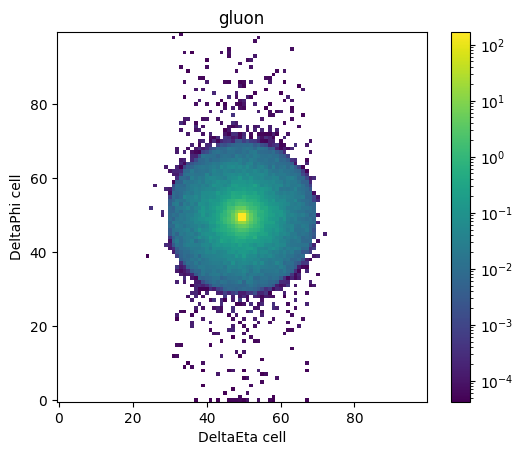

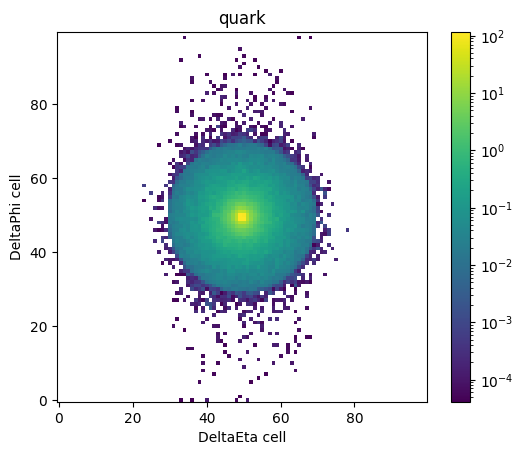

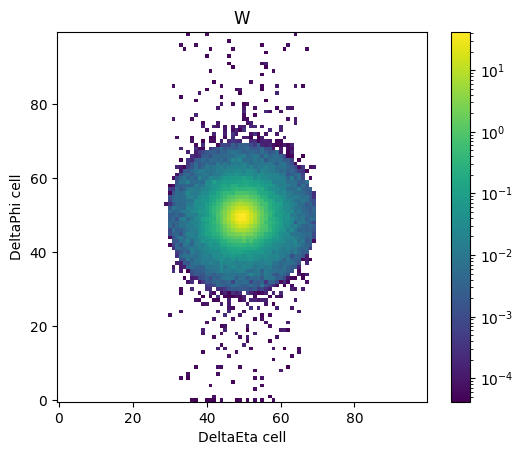

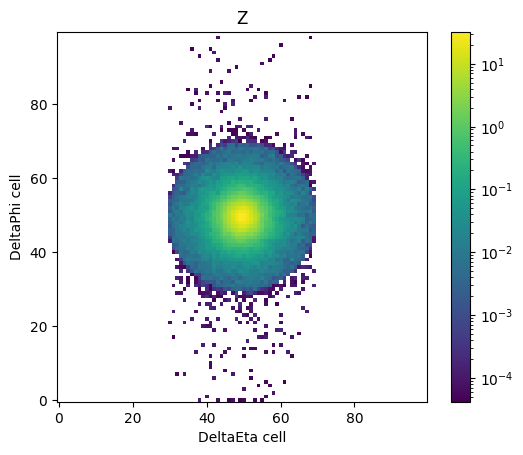

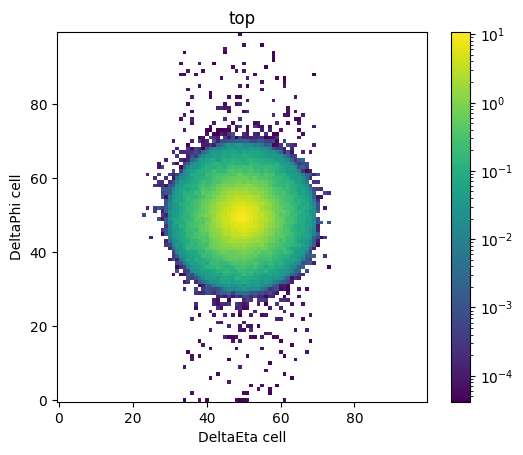

In [ ]:
# plots of sum of jet images for different jet catagories
from matplotlib.colors import LogNorm

image_g = jetImage[np.argmax(target, axis=1) == 0]
image_q = jetImage[np.argmax(target, axis=1) == 1]
image_W = jetImage[np.argmax(target, axis=1) == 2]
image_Z = jetImage[np.argmax(target, axis=1) == 3]
image_t = jetImage[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]

for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm())
    plt.colorbar()
    plt.title(labels[i])
    plt.xlabel('DeltaEta cell')
    plt.ylabel('DeltaPhi cell')
    plt.show()

In [ ]:
# convert one-hot lables in integers labels, and split data

p_label = np.argmax(target, axis=1)

In [ ]:
# preprocess data: split on training, validation, test
# normalize fatures (pixels)

from sklearn.preprocessing import MinMaxScaler ,StandardScaler

scaler = StandardScaler()

# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(jetImage,p_label,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = X_train.reshape(X_train.shape[0],100*100)
X_vali = X_vali.reshape(X_vali.shape[0],100*100)
X_test = X_test.reshape(X_test.shape[0],100*100)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0],100,100)
X_vali = X_vali.reshape(X_vali.shape[0],100,100)
X_test = X_test.reshape(X_test.shape[0],100,100)

X_train = np.expand_dims(X_train, -1)
X_vali = np.expand_dims(X_vali, -1)
X_test = np.expand_dims(X_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (18000, 100, 100, 1)
Y_train shape:  (18000,)
X_vali shape:  (6000, 100, 100, 1)
Y_vali shape:  (6000,)
X_test shape:  (6000, 100, 100, 1)
Y_test shape:  (6000,)


In [ ]:
# transform numpy vectors to pytorch tensors
X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))
X_train_pt = X_train_pt.permute(0,3,1,2)
X_vali_pt = X_vali_pt.permute(0,3,1,2)
X_test_pt = X_test_pt.permute(0,3,1,2)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([18000, 1, 100, 100])
torch.Size([18000])
torch.Size([6000, 1, 100, 100])
torch.Size([6000])
torch.Size([6000, 1, 100, 100])
torch.Size([6000])


In [ ]:
# Data Generator Definition

from operator import indexOf

# create a custom dataset
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random transformation according to the
# base_transforms list
class ContrastiveTransformations(object):
    def __init__(self, base_transforms):
        self.base_transforms = base_transforms

    def __call__(self, x):
        return self.base_transforms(x)

class JetSubStructure(Dataset):
    """JetSubstructure dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else:
            sample = sample

        return sample, label

# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(180.),
                                          transforms.RandomResizedCrop((100,100),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                         ])

In [ ]:
# create the dataset
train_dataset = JetSubStructure(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
val_dataset = JetSubStructure(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms))
test_dataset = JetSubStructure(data=X_test_pt, labels=Y_test_pt, phase='vali')

In [ ]:
from torch.utils.data import DataLoader
# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

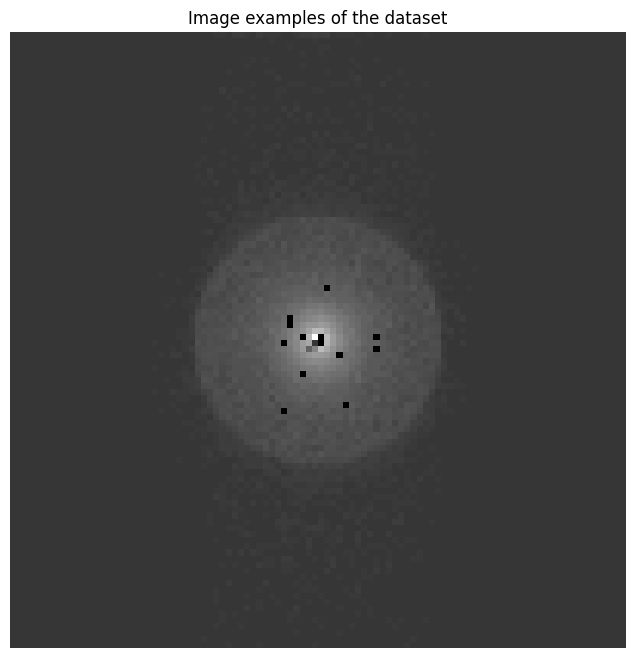

In [ ]:
# Visualize one example

plt.figure(figsize=(8,8))
plt.title("Image examples of the dataset")
plt.imshow(val_dataset[0][0].permute(1,2,0).numpy(),vmax=0.1, cmap='binary') #vmax set to see more clearly the image content
plt.axis('off')
plt.show()
plt.close()

## ViT architecture

Transformers have been originally proposed to process sets (un-ordered lists of items) since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted.

To apply Transformers to sequences (ordered lists), we need to add a positional encoding to the input feature vectors. Hopefully the model will learn by itself how to use this additional information.

In this session we will work with images following the procedure proposed by Dosovitskiy et al.  in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale".

Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches.

### Task 1

**Required task:**

*  divide the image in a sequence of small patches, by implementing a function *img_to_patch* that takes in input a batch of images and divide them in a sequence of small patches

**Solution:**
A batch of images is a tensor
$$
    \underset{(b,c,h,w)}{X}
$$
where the subscript indices are a notation for $X \in \mathbb{R}^{b\times c \times h \times w}$. The batching process is achieved by successive reshaping and index permutations in a NumPy fashion.
Let $p$ be the patch size (considering square patches), and
$$
n_w = w/p \\
n_h =h/p
$$
where we assume to choose $p$ such that $n_h,n_w \in \mathbb{N}$.
Then we reshape the image tensor as
$$
\underset{(b,c,\,n_h,\,p,\,n_w,\,p)}{X}
$$
and permute component indices as follows
$$
[X]_{ijklmn} → [X]_{ikmjln} \quad
$$
in order to get a tensor
$$
 \quad \underset{(b,\,n_h,\,n_w, \,c,\,p,\,p)}{X}
$$
Now, for each image in the batch, patches are stored in a 2-dimensional grid of shape $(n_h,n_w)$, and the total number of patches is $n = n_h n_w$. Thus, by contracting the two grid axes in one of length $n$ we get the final result
$$
 \quad \underset{(b,\,n, \,c,\,p,\,p)}{X}
$$
Furthermore, we implement the possibility of flattening each patch from an image-like rank-3 tensor shape $(c,p,p)$ to a vector of length $(c\cdot p^2)$.

In [ ]:
# manipulations on image to test and understand patch creation process

print('val_dataset[0]:\n',val_dataset[0])
x = val_dataset[0][0]
print('\nval_dataset[0][0].shape = ', x.shape)
x = x.unsqueeze(dim=0) # add batch dimension
print('x.shape = ', x.shape)
B,C,H,W = x.shape
print('H =',H,' W =',W)
patch_size = 20
n_patch_H = H // patch_size
n_patch_W = W // patch_size
n_patch = n_patch_H * n_patch_W
print('n_patch_H = ', n_patch_H,'\nn_patch_W = ', n_patch_W,'\nn_patch = ', n_patch)
x = x.reshape([B,C,H,n_patch_W,patch_size])
x = x.reshape([B,C,n_patch_W,patch_size,n_patch_W,patch_size])
print(x.shape)
x = x.permute([0,2,4,1,3,5])
print(x.shape)
x = x.reshape([B,n_patch,C,patch_size,patch_size])
print(x.shape)



val_dataset[0]:
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor(1.))

val_dataset[0][0].shape =  torch.Size([1, 100, 100])
x.shape =  torch.Size([1, 1, 100, 100])
H = 100  W = 100
n_patch_H =  5 
n_patch_W =  5 
n_patch =  25
torch.Size([1, 1, 5, 20, 5, 20])
torch.Size([1, 5, 5, 1, 20, 20])
torch.Size([1, 25, 1, 20, 20])


In [ ]:
# function to divide the input batch of images in a sequence of small patches

def img_to_patch(x, patch_size, flatten_channels=True):
    # flatten channels is more important as a parameter if we are working with multi channel images
    """
    Inputs:
        x - torch.Tensor representing the batch of images of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid. This is more important when working with
                           multi channel images

        return: x as a sequence with shape
        [B, H*W, C, patch_size*patch_size] if flatten_channels=Flase
        or [B, H*W, C*patch_size*patch_size] if True
    """
    B, C, H, W = x.shape
    n_patch_H, mod_H = divmod(H,patch_size)
    n_patch_W, mod_W = divmod(W,patch_size)

    if (mod_H != 0 or mod_W != 0):
      print('ERROR: patch_size must be integer divisor of H=',H,' and W=',W)
      return 0

    else:
      n_patch = n_patch_H * n_patch_W
      x = x.reshape([B,C,H,n_patch_W,patch_size])
      x = x.reshape([B,C,n_patch_W,patch_size,n_patch_W,patch_size])
      x = x.permute([0,2,4,1,3,5])
      x = x.reshape([B,n_patch,C,patch_size,patch_size])

      if flatten_channels:
        x = x.reshape([B,n_patch,C*patch_size*patch_size])

      return x

In [ ]:
# test function taking a batch of 4 images

img_patches = img_to_patch(val_dataset[0:4][0], patch_size=20, flatten_channels=False)
print('batch of 4 patched images: ',img_patches.shape)

img_patches_flat = img_to_patch(val_dataset[0:4][0], patch_size=20, flatten_channels=True)
print('batch of 4 patched images with flattening: ',img_patches_flat.shape)

batch of 4 patched images:  torch.Size([4, 25, 1, 20, 20])
batch of 4 patched images with flattening:  torch.Size([4, 25, 400])


In [ ]:
# test function for a forbidden choice of patch_size
img_patches_err = img_to_patch(val_dataset[0:4][0], patch_size=22, flatten_channels=False)
print('returned value if ERROR occurs: ',img_patches_err)

ERROR: patch_size must be integer divisor of H= 100  and W= 100
returned value if ERROR occurs:  0


torch.Size([25, 1, 20, 20])


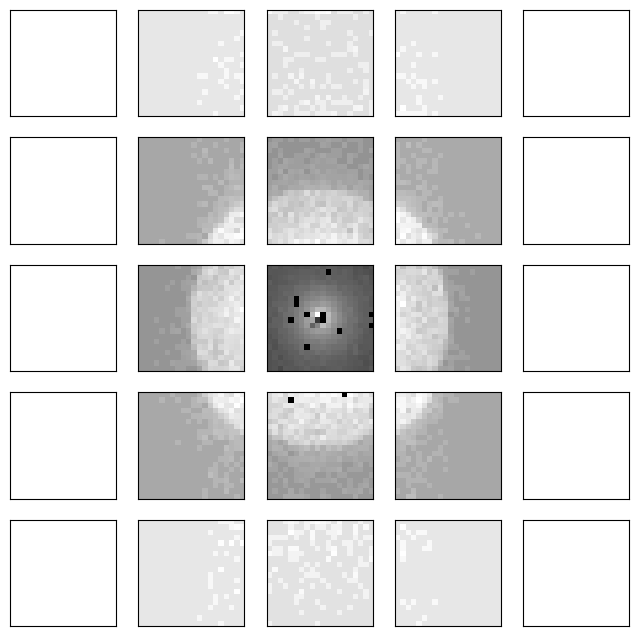

In [ ]:
# take one image and plot patches
fig0 = img_patches[0]
print(fig0.shape)

plt.figure(figsize=(8,8))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(fig0[i].permute(1,2,0).numpy(), vmax=0.1, cmap='binary') #vmax set to see more clearly the image content
  #plt.axis('off')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout
plt.show()
plt.close()


### Task 2

**Required task:**

*  implement the forward part of a standard nmulti-head attention layer for a transformer encoder architecture



**Solution:**

In [ ]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for
    #  a tranformer encoder architecture

    #  structure:
    #   MHA: pre layer normalization (see Ruibin Xiong et al. (2020)) + multi-head attention (pytorch implementation) + layer normalization
    #   MLP: dense + gelu + droput + dense + dropout

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #                (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network

    #    ^
    #    |_____    NOR2(x) + NOR2(MHA(NOR1(x))) + MLP(NOR2(MHA(NOR1(x)))): output (L,B,embed_dim)
    #    |     ^
    #  -----   |
    # | MLP |  |
    #  -----   |
    #    |_____|
    #    |
    #  -----
    # | NOR |
    #  -----
    #    |_____    x + MHA(NOR1(x))
    #    |     ^
    #  -----   |
    # | MHA |  |
    #  -----   |
    #    |     |
    #  -----   |
    # | NOR |  |
    #  -----   |
    #    |_____|
    #    |        x

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads) #this pytroch function implements a full MH-Attention block (see https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):

        # NOTE: the nn.MultiheadAttention expects 3 inputs (Q,K,V) tensors
        # (3 times the same tensor in case of selfattention)

        # pre-attention LayerNorm
        h = self.layer_norm_1(x)
        # self-attention: nn.MultiHeadAttention returns tuple (output,out_weights)
        h, weights = self.attn(query=h,key=h,value=h)
        # residual connection
        x = h + x
        # post-attention LayerNorm
        x = self.layer_norm_2(x)
        # MLP
        h = self.mlp(x)
        # residual connection
        x = h + x

        return x

In [ ]:
# instance of AttentionBlock class

embed_dim = 64
hidden_dim = 128
num_heads = 8

att_block = AttentionBlock(embed_dim=embed_dim,hidden_dim=hidden_dim,num_heads=num_heads)

print(att_block)

AttentionBlock(
  (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)


In [ ]:
# test layer on a sequence of n_token vectors of length embed_dim

n_token = 128
test_input = torch.rand([n_token,embed_dim])
print('input shape: ', test_input.shape )

out = att_block(test_input)
print('output shape: ',out.shape)

input shape:  torch.Size([128, 64])
output shape:  torch.Size([128, 64])


In [ ]:
# save model in ONNX for plotting
input_names = ['input']
output_names = ['output']
torch.onnx.export(att_block, test_input,path+"att_block.onnx", input_names=input_names, output_names=output_names )

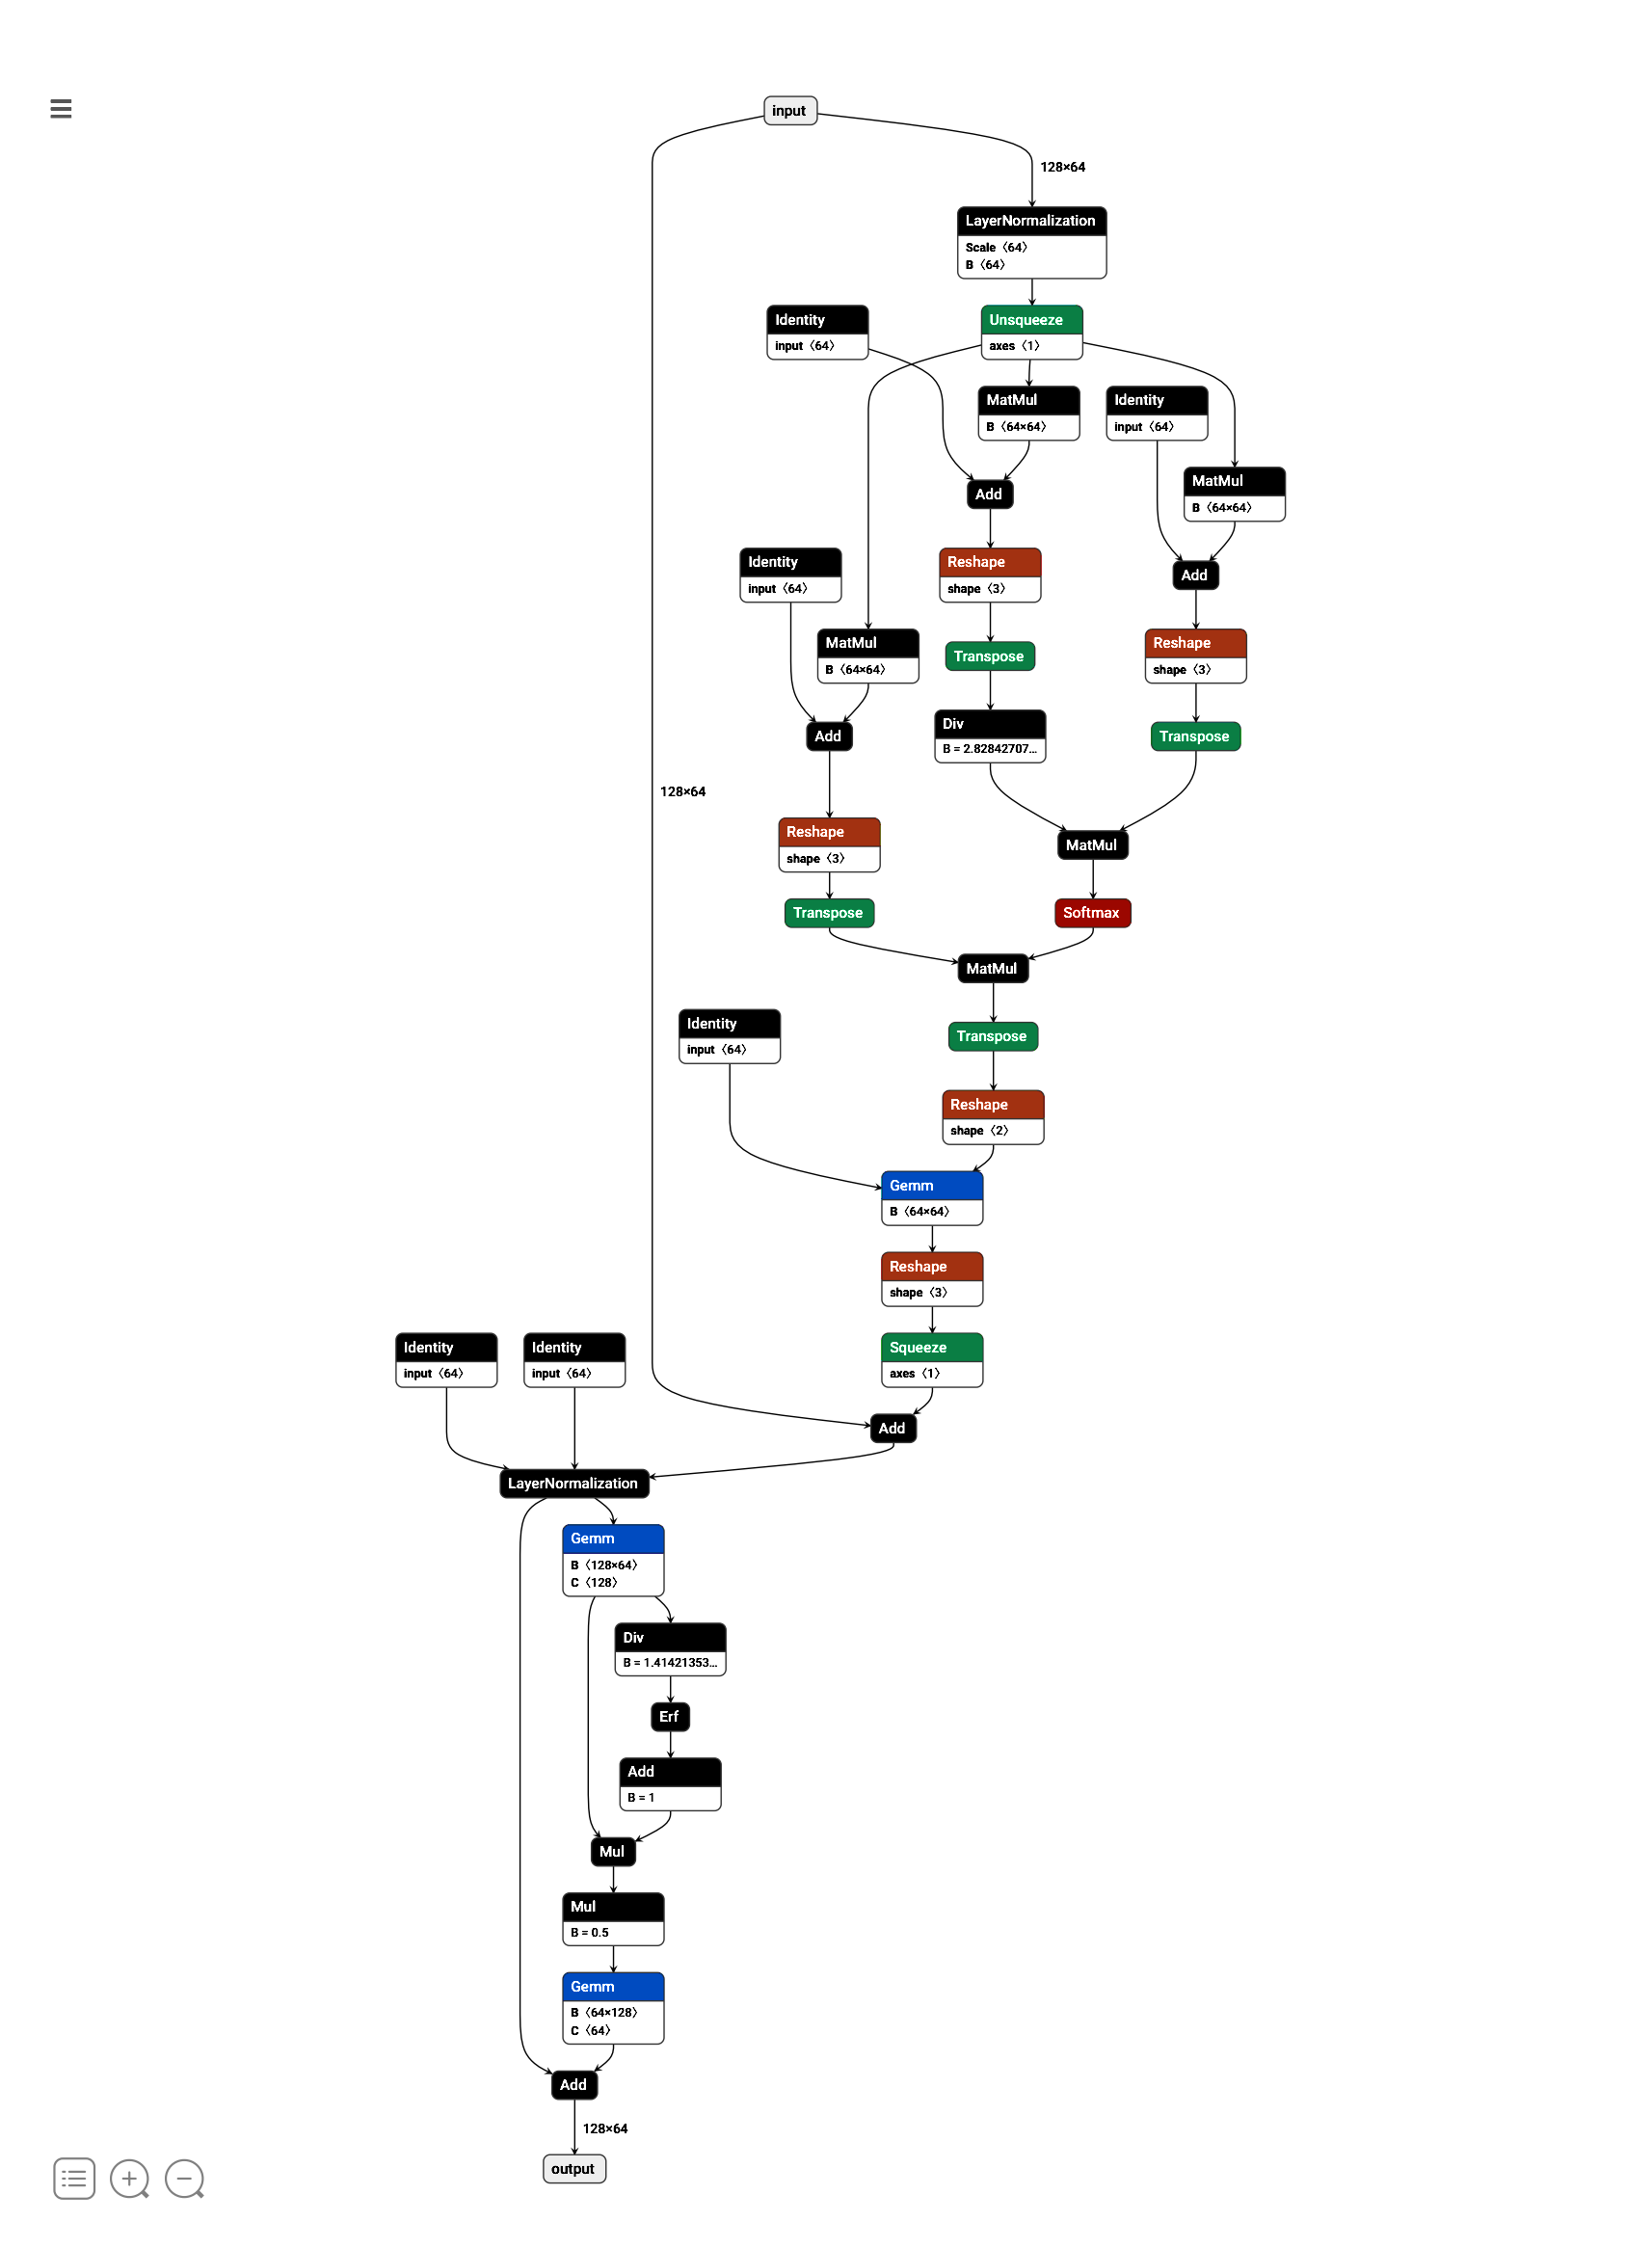

In [ ]:
# model plot obtained from ONNX file using NETRON web app
# https://netron.app/
from IPython.display import Image

Image(path+'attention_block.png')

### Task 3

**Task:** build the Vision Transformer module's forward function.

Needs:

- a linear projection layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each patch independently as input.

- a classification token that is added to the input sequence. Use the output feature vector of the first token (CLS token in short) for determining the classification prediction.

- learnable positional encodings that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions [Here you can find a good explanation of positional encodings for NLP sequences with varing length](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). Suggestion for this task is to use a simple learnable set of parameters that wil be learned during the training (already implemented).

- an MLP head that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.


Vision Transformer Architecture:


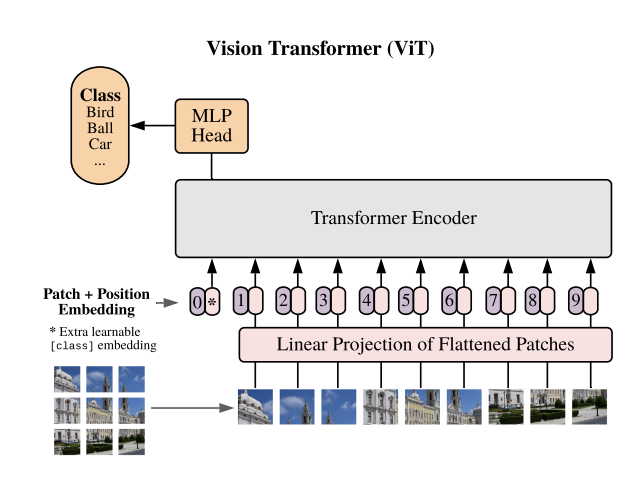

In [ ]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/ViT.png', width=500)

**Solution:**

each block of the model is first implemented separately and intermediate outputs are printed out, then they are combined together in ```VisionTransformer()``` class.

In [ ]:
# model parameters

embed_dim = 64
hidden_dim = 128
num_heads = 8
num_layers = 4
patch_size = 20
num_channels = 1
num_patches = 25
num_classes = 5
dropout = 0.30

In [ ]:
# take mini-batch of examples

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
#xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
#yb=yb.type(torch.long).to(device)
print('mini batch input images:',xb.shape)
print('mini batch targets:',yb.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


mini batch input images: torch.Size([256, 1, 100, 100])
mini batch targets: torch.Size([256])


In [ ]:
# Preprocess input

# apply img_to_patch
xb = img_to_patch(xb, patch_size, flatten_channels=True)
print('mini batch of patched (flattened) images:',xb.shape)

# embed the patches using the input_layer
input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
xb = input_layer(xb)
print('mini batch of input embeddings:', xb.shape)


mini batch of patched (flattened) images: torch.Size([256, 25, 400])
mini batch of input embeddings: torch.Size([256, 25, 64])


In [ ]:
B = xb.shape[0]
print('#elem in mini batch:',B)
Np = xb.shape[1]
print('#patches for images in minibatch:',Np)

# learnable classification token
cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
print('learnable classification (CLS) token:',cls_token.shape)
cls_token_b = cls_token.repeat(B, 1, 1)
print('stack of CLS token repeated for each elem of mini batch:',cls_token_b.shape)
# for each image in mini batch, add CLS token to the sequence of patch embeddings (axis 1)
xb = torch.cat([cls_token_b, xb], dim=1)
print('mini batch of [CLS token, patch embeddings]:',xb.shape)

#elem in mini batch: 256
#patches for images in minibatch: 25
learnable classification (CLS) token: torch.Size([1, 1, 64])
stack of CLS token repeated for each elem of mini batch: torch.Size([256, 1, 64])
mini batch of [CLS token, patch embeddings]: torch.Size([256, 26, 64])


In [ ]:
# learnable position embedding
pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
print('learnable postional embeddings:',pos_embedding.shape)
# for each image in minibatch, sum pos embeddings to patch embeddings
xb = xb + pos_embedding[:,:Np+1] # broadcast pos_embedding over axis 0
print('mini batch of { [CLS token,patch embeddings] + pos_embeddings }',xb.shape)



learnable postional embeddings: torch.Size([1, 26, 64])
mini batch of { [CLS token,patch embeddings] + pos_embeddings } torch.Size([256, 26, 64])


In [ ]:
# Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])

# Apply transformer encoder to positionally embedded input xb to get output representation Hb
Hb = transformer(xb)
print('mini batch of ouput representations:',Hb.shape)


mini batch of ouput representations: torch.Size([256, 26, 64])


In [ ]:
# for each elem of mini batch, take the output representation hb of CLS token
hb = Hb[:,0]
print('mini batch of output representations of CLS token:', hb.shape,'\n')
print(hb)

# apply dropout
drop_layer = nn.Dropout(dropout)
hb = drop_layer(hb)
print('\nafter dropout (here printed without rescaling by 1/(1-p)()):\n')
print(hb*(1-dropout))


mini batch of output representations of CLS token: torch.Size([256, 64]) 

tensor([[ 2.5826, -0.3777, -0.6030,  ...,  0.9532,  0.1697,  0.1371],
        [ 2.9452, -0.4017, -0.4354,  ...,  1.1463,  0.3396,  0.0111],
        [ 2.2850, -0.1621, -0.8080,  ...,  1.1632,  0.1147, -0.1081],
        ...,
        [ 1.9596, -0.2209, -1.0215,  ...,  1.2004,  0.3068, -0.2506],
        [ 2.5310,  0.1474, -1.2847,  ...,  1.1379, -0.4150,  0.5410],
        [ 2.2020, -0.0739, -0.5631,  ...,  0.6941, -0.0031,  0.7188]],
       grad_fn=<SelectBackward0>)

after dropout (here printed without rescaling by 1/(1-p)()):

tensor([[ 2.5826, -0.3777, -0.6030,  ...,  0.9532,  0.1697,  0.1371],
        [ 0.0000, -0.0000, -0.4354,  ...,  1.1463,  0.3396,  0.0000],
        [ 2.2850, -0.1621, -0.8080,  ...,  1.1632,  0.0000, -0.1081],
        ...,
        [ 0.0000, -0.2209, -1.0215,  ...,  1.2004,  0.3068, -0.2506],
        [ 0.0000,  0.1474, -0.0000,  ...,  0.0000, -0.4150,  0.5410],
        [ 0.0000, -0.0739, -0.0

In [ ]:
# MLP Classifier (embed_dim -> num_classes)
mlp_head = nn.Sequential(
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, num_classes)
)

# apply MLP classification head to output representation of CLS token
outb = mlp_head(hb)
print('mini-batch of classifier outputs:',outb.shape)


mini-batch of classifier outputs: torch.Size([256, 5])


In [ ]:
class VisionTransformer(nn.Module):
    #  Classifier based on a ViT  architecture implementation
    #  arguments:
    #   embed_dim  - Dimensionality of embedding in input fetaure vector to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #   num_channels - Number of channels of the input (3 for RGB)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer
    #   patch_size - Number of pixels that the patches have per dimension
    #   num_patches - Maximum number of patches an image can have
    #   num_classes- Number of categories for the classification task
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, patch_size, num_patches, num_classes, dropout=0.0):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size

        # input layer (a dense layer projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])

        # MLP Classifier (embed_dim -> num_classes)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.dropout = nn.Dropout(dropout)


        #parameters / embedding
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        # this is our positional  embedding. It is initialized as a random number but it is learnable so it will be optimized during training.
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

    def forward(self, X):

        # Apply img_to_patch
        X = img_to_patch(X, patch_size, flatten_channels=True)
        B = X.shape[0] # mini-batch size
        Np = X.shape[1] # num patches for images in minibatch:

        # Embed the patches using the input_layer
        X = self.input_layer(X)

        # Add CLS token:
        # stack of CLS token repeated for each elem of mini batch
        cls_token = self.cls_token.repeat(B, 1, 1)
        # for each image in mini batch, add CLS token to the sequence of patch embeddings (axis 1)
        X = torch.cat([cls_token, X], dim=1)

        # Add positonal embeddings:
        # for each image in minibatch, sum pos embeddings to patch embeddings
        X = X + self.pos_embedding[:,:Np+1] # broadcast pos_embedding over axis 0

        # Apply Transforrmer:
        # positionally embedded input X fed to transformer encoder -> output representation H
        H = self.transformer(X)

        # Take CLS output representation:
        # for each elem of mini batch, take the output representation h of CLS token
        h = H[:,0]

        # Apply dropout
        h = self.dropout(h)

        # Perform classification prediction:
        # apply MLP classification head to output representation of CLS token
        out = self.mlp_head(h)

        return out

In [ ]:
# instantiate the model

# NOTE: embed_dim MUST be an integer multiple of num_heads
model_kwargs={
              'embed_dim': 64,
              'hidden_dim': 128,
              'num_heads': 8,
              'num_layers': 4,
              'patch_size': 20,
              'num_channels': 1,
              'num_patches': 25,
              'num_classes': 5,
              'dropout': 0.30
             }

model = VisionTransformer(**model_kwargs)

In [ ]:
# test the model on one batch to check everything is ok before training it

model.to(device) #move the model on device (cpu/gpu)

xb,yb=next(iter(train_loader)) #take a mini batch from the trainign dataloader
xb=xb.type(torch.float).to(device) #move torch tensors to device (cpu or GPU)
yb=yb.type(torch.long).to(device)
print(xb.shape)
print(yb.shape)

out=model(xb) #apply the model on the input batch
print(out.shape)

torch.Size([256, 1, 100, 100])
torch.Size([256])
torch.Size([256, 5])


In [ ]:
# print model structure

print(model)


VisionTransformer(
  (input_layer): Linear(in_features=400, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), 

## Training of the Model

In [ ]:
#loss
loss_func = nn.CrossEntropyLoss() #cross entropy loss

#metric accuracy from torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy
metric_func = MulticlassAccuracy(num_classes=5)
metric_func = metric_func.to(device)

# optimizer + lr schedular
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,30,35], gamma=0.2)

In [ ]:
#Checkpoints (to save model parameters during training)

# this is implemented by writing a python class that uses the torch.save method

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [ ]:
# in pytorch you are responsible of writing the training loop, this can be done by implementig specific
# python functions for the training and validation steps, or just, like in this example, by using a simple plain
# python loop

#training loop

epochs = 40 #number of epochs (actually needs ~100 epochs with ~60-70k input examples)

import time

save_best_model = SaveBestModel() #initialize checkpoint function

# dfine python lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in train_loader: #takes a batch from the train dataloader
        counter += 1
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.long).to(device)

        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute accuracy

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()

    # normalize loss and metric by number of batches
    train_loss = train_loss/(counter)
    train_metric = train_metric/(counter)

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # evaluation step (same as training but w/o backpropagation)

    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.long).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/(counter)
    vali_metric = vali_metric/(counter)

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)

    elapsed_time = time.time()-t0
    current_lr = lr_scheduler.get_last_lr()[0]
    print("epoch: %d, time(s): %.2f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f,  lr : %1.2e" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step()


Best validation loss: 1.2644391655921936

Saving best model for epoch: 1

epoch: 1, time(s): 23.72, train loss: 1.516809, train metric: 0.298112, vali loss: 1.264439, vali metric: 0.531682,  lr : 1.00e-03

Best validation loss: 1.0693178003033001

Saving best model for epoch: 2

epoch: 2, time(s): 18.92, train loss: 1.232291, train metric: 0.496959, vali loss: 1.069318, vali metric: 0.566902,  lr : 1.00e-03

Best validation loss: 1.0530659506718318

Saving best model for epoch: 3

epoch: 3, time(s): 17.78, train loss: 1.164747, train metric: 0.530047, vali loss: 1.053066, vali metric: 0.563242,  lr : 1.00e-03

Best validation loss: 1.0252932508786519

Saving best model for epoch: 4

epoch: 4, time(s): 18.13, train loss: 1.142630, train metric: 0.540129, vali loss: 1.025293, vali metric: 0.590662,  lr : 1.00e-03

Best validation loss: 1.0237169861793518

Saving best model for epoch: 5

epoch: 5, time(s): 19.05, train loss: 1.125524, train metric: 0.549348, vali loss: 1.023717, vali met

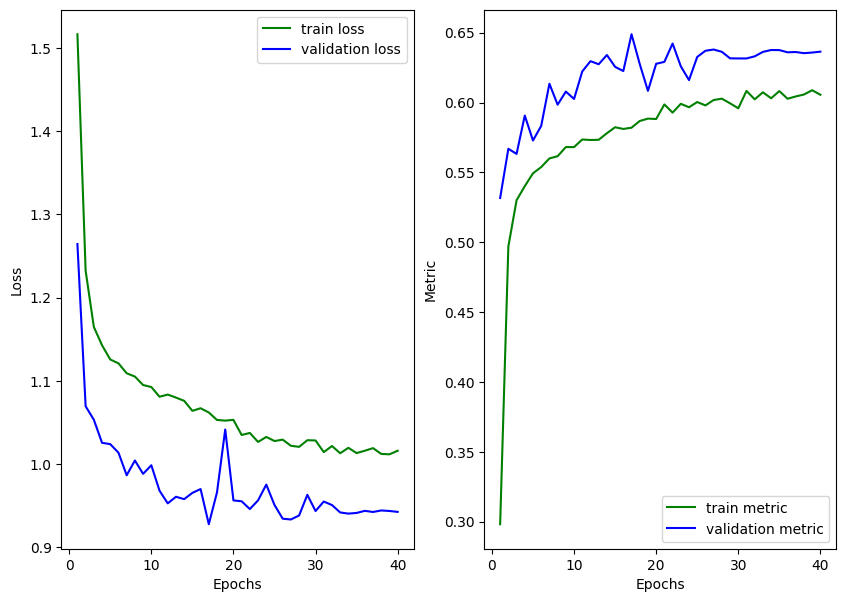

In [ ]:
# plot training results (loss and accuracy vs epoch)

plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [ ]:
# load the best model
checkpoint = torch.load('./best_model.pth')
print('Best model at epoch: ', checkpoint['epoch'])

model = VisionTransformer(**model_kwargs)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Best model at epoch:  17


VisionTransformer(
  (input_layer): Linear(in_features=400, out_features=64, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm_2): LayerNorm((64,), 

In [ ]:
# inference on test set
pred_prob = torch.empty(size=(0,5), device=device) #note the device parameter, this allows to create the torch tensors directly in the needed device
pred_val = torch.empty(size=(0,), device=device)
ground_truth = torch.empty(size=(0,), device=device)

model.to(device)

test_loss = 0.0
test_metric = 0.0

counter=0
with torch.no_grad():
  for xb, yb in test_loader:
    counter += 1
    xb=xb.type(torch.float).to(device)
    yb=yb.type(torch.long).to(device)
    res = model(xb)
    pre = torch.softmax(res, dim=1)
    val = pre.argmax(dim=1)
    pred_prob = torch.cat((pred_prob, pre), dim=0)
    pred_val = torch.cat((pred_val, val), dim=0)
    ground_truth = torch.cat((ground_truth, yb), dim=0)
    vloss = loss_func(res, yb)
    vmetric = metric_func(res, yb)
    test_loss += vloss.item()
    test_metric += vmetric.item()

test_loss = test_loss/(counter)
test_metric = test_metric/(counter)

predict_val = pred_val.cpu().data.numpy()
predict_prob = pred_prob.cpu().data.numpy()
true_val = ground_truth.cpu().data.numpy()

print('test loss: ', test_loss)
print('test average accuracy: ', test_metric)

test loss:  0.9315847853819529
test average accuracy:  0.6536082401871681


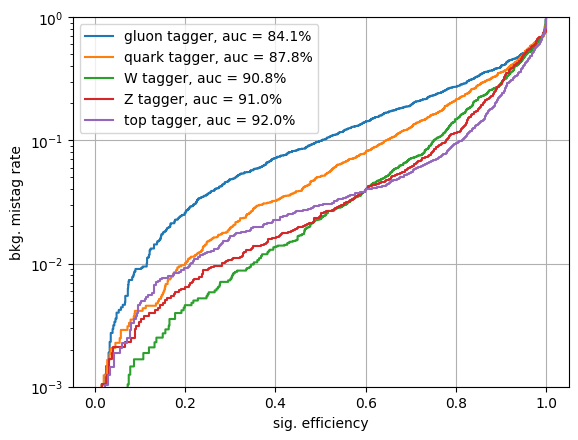

In [ ]:
from sklearn.metrics import roc_curve, auc

# print ROC curves
fpr = {}
tpr = {}
auc1 = {}
plt.figure()
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve((true_val==i), predict_prob[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [ ]:
#function to print a formatted confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(true_val, predict_val, normalize='true')
print("Confusion Matrix:")
print("")
print_cm(c_mat,labels)

Confusion Matrix:

          gluon quark     W     Z   top 
    gluon  0.60  0.12  0.05  0.04  0.19 
    quark  0.32  0.50  0.07  0.04  0.07 
        W  0.10  0.05  0.78  0.07  0.01 
        Z  0.07  0.04  0.25  0.62  0.01 
      top  0.13  0.00  0.06  0.05  0.76 
